# Basic text recognition

In this tutorial I will explore the basics for text recognition with tensorflow, following one of the basic Keras tutorials. The exercise will be to use the Large Movie Review Dataset (a subset of IMDB) to perform sentiment analysis. Sentiments are divided into two categories: positive and negative. As such, this will be a binary classification problem.

The training and testing sets are balanced, _i.e._ they contain an equal number of positive and negative reviews.

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil 
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

Directories 'pos' and 'neg' contain many text files, let's see one of them.

In [14]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Load dataset
We need to load the data off disk and prepare it into a format suitable for training. We can use the 'text_dataset_from_directory' utility. 

We need two folders on disk, corresponding to class_a and class_b. We will thus remove the additional folders from this dataset.

In [16]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, we use the aforementioned utility to create a labeled tf.data.Dataset object. We split the dataset into three splits: train, validation and test. In the IMDB dataset we don't have the validation set, so we create it using a 80:20 split.

In [30]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


We can also iterate over the dataset and print out a few examples:

In [31]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

The reviews contain raw text and occasional HTML tags. We will see later how to deal with those. Let's see what the labels 0 and 1 correspond to:

In [32]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next we prepare validation and test datasets:

In [35]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train/',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [36]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test/',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


### Prepare dataset for training

With text, we need to standardize, tokenize and vectorize the data:

- Standardization: preprocessing the text, _e.g._ to remove punctuation or HTML elements. This simplifies the dataset.
- Tokenization: splitting strings into tokens (_e.g._ splitting a sentence into individual words).
- Vectorization: converting tokens into numbers so that they can be fed to a neural network.

All can be accomplished with the `tf.keras.layers.TextVectorization` layer. To remove HTML tags, however, we will need to write a custom function.

In [37]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

Now it's time to use the `.TextVectorization` layer. This standardizes, tokenizes and vectorizes the data. The `output_mode` needs to be set to `int` so that it creates unique integer indeces for each token.

We are using the default split function, as well as the custom standardization function that we used above. The first variables defined are in order to specify limits to the model. 

In [38]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

And then of course we call `adapt` to fit the state of the preprocessing layer to the dataset.

The definition of `train_text` takes out the labels. Because raw_train_ds comes as sorts of tuples in the style of `(text, label)`, the mapping takes the tuple `x, y` and makes it only `x`. 

In [39]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's see just one batch (32 reviews and labels) from the dataset:

In [40]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [41]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  85,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2421,
           1,   51,   22,   25,  404,  251,   12,  308,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

To see what each token corresponds to, we can:

In [43]:
print("1287 --> ", vectorize_layer.get_vocabulary()[1287])
print("50 --> ", vectorize_layer.get_vocabulary()[50])

1287 -->  lovely
50 -->  more


We are almost ready to train the model. We need now to apply a final preprocessing step, which is applying `TextVectorization` to train, validation and test dataset.

In [44]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance
Two important methods to use when loading data, to avoid I/O blocking:
- `cache()` keeps data in memory after it's loaded off disk. It will ensure that the dataset does not become a bottleneck while training. If the dataset is too large to fit in memory, this method can be used to create a performant on-disk cache, which is more efficient than reading many small files.
- `prefetch()` overlaps data preprocessing and model execution while training.

In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model

Working with the following layers:
1. `Embedding`: this takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are `(batch, sequence, embedding)`.
2. `GlobalAveragePooling1D`: this returns a fixed-length output vector for each example by averaging over the sequence dimension. It allows the model to handle the output of variable length, as easy as possible.
3. `Dense`: self-explanatory.

In addition there is a `Dropout` after every layer.

In [46]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

### Loss function and optimizer
We will use `losses.BinaryCrossentropy` as a loss function, and the Adam optimizer.

In [47]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

In [48]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 20s 31ms/step - loss: 0.6629 - binary_accuracy: 0.6956 - val_loss: 0.6139 - val_binary_accuracy: 0.7720
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5482 - binary_accuracy: 0.8012 - val_loss: 0.4984 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4449 - binary_accuracy: 0.8449 - val_loss: 0.4206 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3777 - binary_accuracy: 0.8669 - val_loss: 0.3743 - val_binary_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3360 - binary_accuracy: 0.8777 - val_loss: 0.3457 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3047 - binary_accuracy: 0.8891 - val_loss: 0.3268 - val_binary_accuracy: 0.8700
Epoch 7/10
625/625 [==============================] - 5s 7ms/s

### Evaluate the model

In [49]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 50s 63ms/step - loss: 0.3106 - binary_accuracy: 0.8730
Loss:  0.31063395738601685
Accuracy:  0.8730000257492065


This was quite a small approach and already we achieve 87.3% of accuracy! Let's create a plot of accuracy and loss over time, to see if we could benefit from longer training.

In [50]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

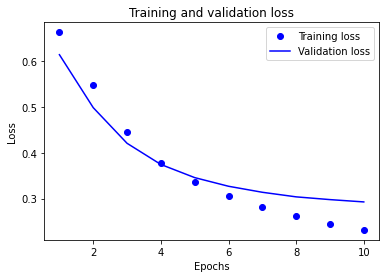

In [52]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

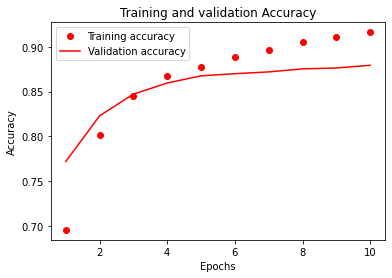

In [53]:
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

We can see some signs of overfitting to the training dataset, as the validation loss and accuracy seem to flatten out before the training. One way to stop the training when the validation accuracy is no longer increasing is to use the `tf.keras.callbacks.EarlyStopping` callback.

### Export the model
We export the model and use it on `raw_test_ds`.

In [54]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 13ms/step - loss: 0.3106 - accuracy: 0.8730
0.8730000257492065


## What about inference on new data?
We can use `.predict()` to make inference. Let's invent a new dataset:

In [55]:
examples = [
    "The movies was really great!",
    "Wow! I loved this movie, I hope they will make another one",
    "The movie was terrible... nothing to add.",
    "Not terrible nor amazing, although it had its moments."
]

export_model.predict(examples)

1/1 [==============================] - 0s 266ms/step


array([[0.611505  ],
       [0.567512  ],
       [0.24296515],
       [0.52588147]], dtype=float32)